I always liked to know about the parameters the meteorologists consider before forecasting weather, so I found the data set interesting. From an expert's point of view, this data set is pretty simple though. For the beginners, this notebook can be a good source of learning for:
* How balancing is done for an imbalanced data set
* How label encoding is done for categorical variables
* How sophisticated imputation like MICE is used
* How outliers can be detected and excluded from data
* How filter method and wrapper methods are used for feature selection
* How speed and performance trade-off can be compared for various popular models
* Which metric can be the best one for judging the performance on imbalanced data set: Accuracy, F1-Score or Cohen's Kappa

If you find my notebook interesting, kindly upvote!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data

In [ ]:
import pandas as pd
full_data = pd.read_csv('/content/drive/MyDrive/Colab Data/weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data Exploration
We will check the no. of rows and columns first. Then we will check the size of data set to decide whether it requires any compression of size.

In [ ]:
full_data.shape

(145460, 23)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Both "RainToday" and "RainTomorrow" are object (Yes/No). We will convert them into binary (1/0) for our convenience.

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Next, we will check whether the dataset is imbalanced or balanced. If the dataset is imbalanced, we need to undersample majority or oversample minority to balance it. 

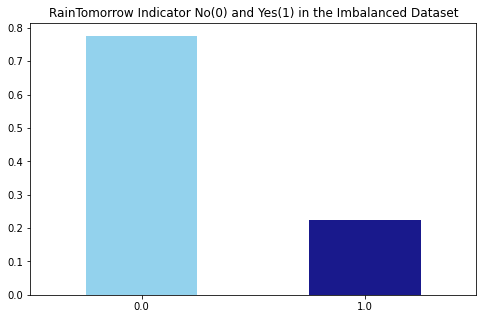

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that presence of "0" and "1" are almost in the ratio 78:22. So there is a class imbalance and we have to handle it. For tackling class imbalance, we will use **oversampling of minority class** here. Since the size of the data set is quite small, undersampling of majority class would not make much sense here. 

# Handling Class Imbalance

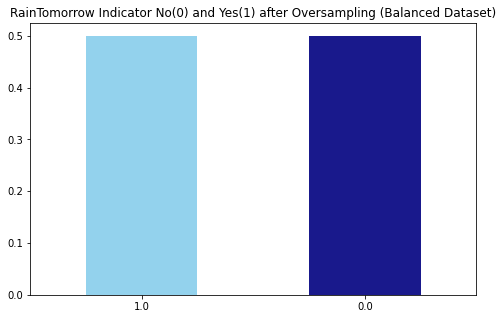

In [ ]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Now, we will now check the missing data pattern in the dataset.

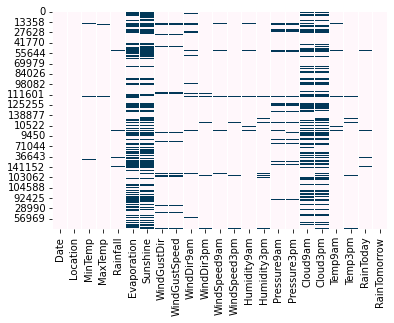

In [ ]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

Visibly, 'Evaporation','Sunshine','Cloud9am','Cloud3pm' are the features having high missing percentage. So we will check the missing data details for these 4 features.

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


We observe that all 4 features have <50% missing data. So instead of completely discarding them, we will consider them in our model with proper imputation.

# Imputation and Transformation
We will impute categorical columns with mode, and then we will use label encoder to convert them into numeric ones. Once the full dataframe's all columns get converted to numeric ones, we will impute missing values (NaN etc.) using **MICE package (Multiple Imputation by Chained Equations)**. Afterwards, we will detect outliers using **Inter-Quartile Range** and remove them to get the final working data set. Finally, we will check correlation among different variables, and if we find any pair of highly correlated variables, we will discard one keeping the other.

In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
MiceImputed.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,396.0,2.0,13.4,22.9,0.6,5.734653,7.446035,13.0,44.0,13.0,14.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.848545,16.9,21.8,0.0,0.0
1,397.0,2.0,7.4,25.1,0.0,5.639329,11.520531,14.0,44.0,6.0,15.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.731945,2.625892,17.2,24.3,0.0,0.0
2,398.0,2.0,12.9,25.7,0.0,7.762688,12.348852,15.0,46.0,13.0,15.0,19.0,26.0,38.0,30.0,1007.6,1008.7,1.827673,2.000000,21.0,23.2,0.0,0.0
3,399.0,2.0,9.2,28.0,0.0,5.977293,11.811634,4.0,24.0,9.0,0.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.233996,2.116194,18.1,26.5,0.0,0.0
4,400.0,2.0,17.5,32.3,1.0,6.852837,5.728406,13.0,41.0,1.0,7.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0


Now, we will check whether all "NaN" values are imputed completely or not.

In [ ]:
MiceImputed.isna()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133585,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
117307,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
87307,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
56427,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


So, after MICE imputation, the dataframe does not have any "NaN" value. We will now detect and discard the outliers from data set based on Inter-Quartile Range.

In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [ ]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

We observe that the original dataset was having the shape (87927, 24). After running outlier-removal code snippet, the dataset is now having the shape (86065, 24). So, the dataset is now free of 1862 outliers. We will now check for multi-collinearity i.e. whether any feature is highly correlated with another.

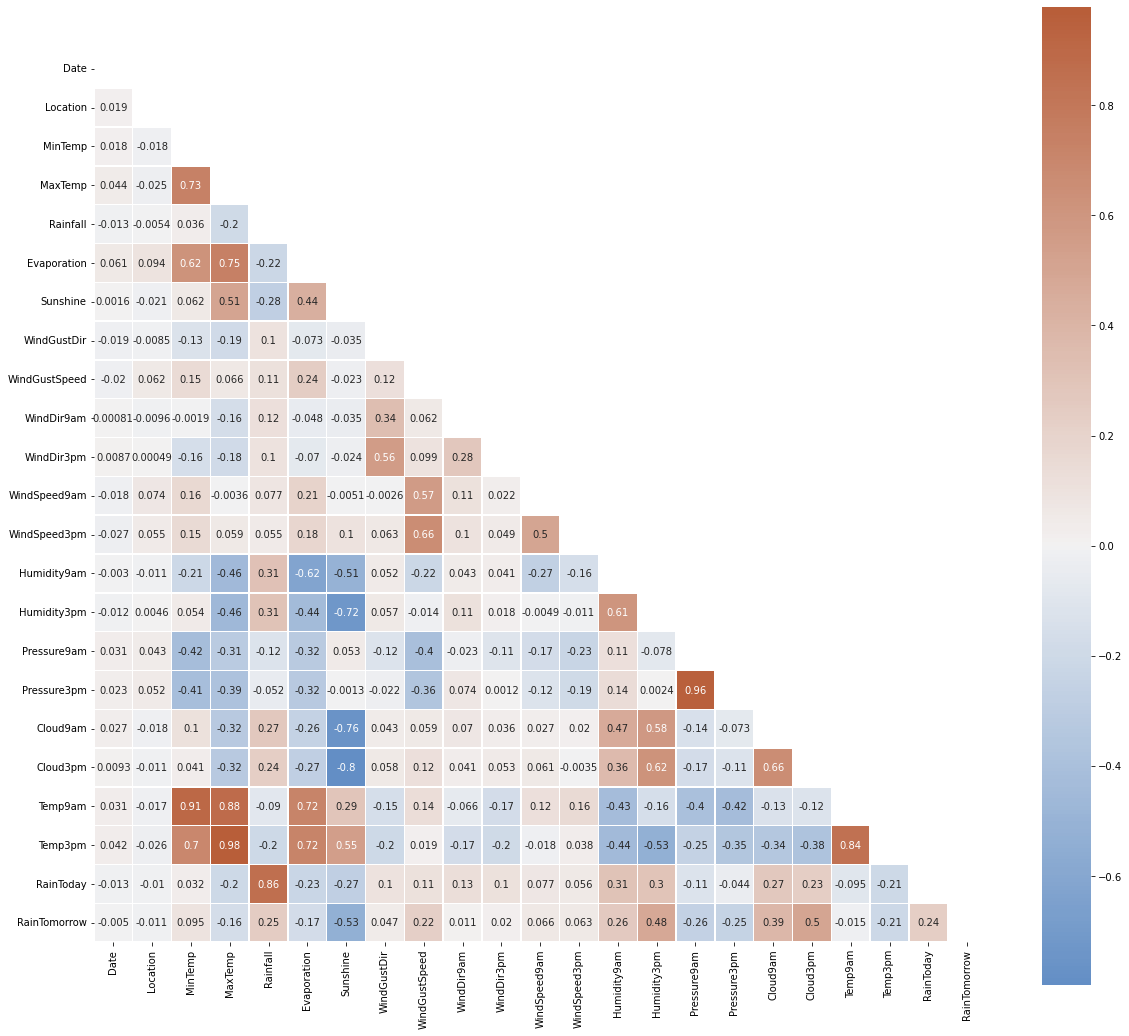

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

The following pairs of features are having high correlation between them:

* MaxTemp and MinTemp
* Pressure9am and Pressure3pm
* Temp9am and Temp3pm
* Evaporation and MaxTemp
* MaxTemp and Temp3pm
But in no case, the correlation value is equal to a perfect "1". So we are not discarding any feature. 

However, we can dig deeper into pairwise correlation among these highly correlated features by looking at the following pairplot. Each of the pairplots shows very clearly distinguishable clusters of RainTomorrow "yes" and "no". There is very minimal overlap between them.

# Feature Selection
We will use both filter method and wrapper method for feature selection.

**(1) Feature Selection by Filter Method (Chi-Square Value):** Before performing this, we need to standardize our data first. We are using MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,0.933333,0.551188,0.615385,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,1.000000,0.173240,0.564103,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,1.000000,0.527566,0.666667,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,0.000000,0.338592,0.230769,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,0.466667,0.244105,0.512821,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


We can observe that "Sunshine", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm" are having higher importance compared to other features.

**(2) Feature Selection by Wrapper Method (Random Forest):**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


*This is quite interesting to see all feature importances except for RISK_MM are nearing to zero*. This is possible in two scenarios. Either when all the features have high correlation among each other or when the features actually have very very low relative feature importances w.r.t. the target variable. Since we already plotted correlation, we know that the first possibility is not true. We will cross-check if the second possibility is true by using **Permutation Importance**.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

We can observe that all features except "RISK_MM" have very very low relative importance (all nearing to zero) with respect to target variable "RainTomorrow". As explained by the dataset creator [Joe Young](http://www.kaggle.com/jsphyg), "RISKMM is the amount of rainfall in millimeters for the next day. It includes all forms of precipitation that reach the ground, such as rain, drizzle, hail and snow. And it was the column that was used to actually determine whether or not it rained to create the binary target. **Since it contains information directly about the target variable, including it would leak the future information to our model**" (Quoted from his comment). So "RISK_MM" is excluded from the model. "Date" is also excluded from the model for the obvious reason since it is not adding any relevance in the current context.

# Training with Different Models
We will split the entire data set into training (75%) and testing (25%) sets respectively. For getting better results, we will standardize our X_train and X_test data (i.e. features without target for training and testing data sets).

In [ ]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.7, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

**Model 1: Logistic Regression penalized by Lasso**

Accuracy = 0.7954197323154961
ROC Area under Curve = 0.7893164684378858
Cohen's Kappa = 0.5822651496994611
Time taken = 0.9738497734069824
              precision    recall  f1-score   support

         0.0    0.80343   0.84022   0.82141     66897
         1.0    0.78410   0.73842   0.76057     52572

    accuracy                        0.79542    119469
   macro avg    0.79377   0.78932   0.79099    119469
weighted avg    0.79492   0.79542   0.79464    119469



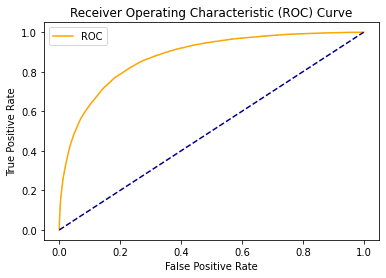

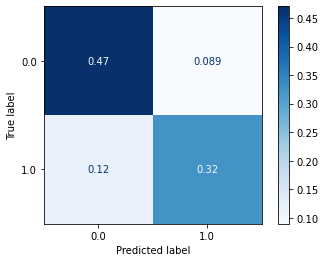

In [ ]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

**Model 2: Decision Tree**

Accuracy = 0.8252517389448308
ROC Area under Curve = 0.8247830496092518
Cohen's Kappa = 0.64687461419076
Time taken = 0.32624149322509766
              precision    recall  f1-score   support

         0.0    0.85480   0.82869   0.84154     66897
         1.0    0.79017   0.82087   0.80523     52572

    accuracy                        0.82525    119469
   macro avg    0.82248   0.82478   0.82339    119469
weighted avg    0.82636   0.82525   0.82556    119469



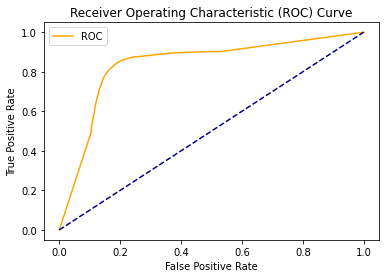

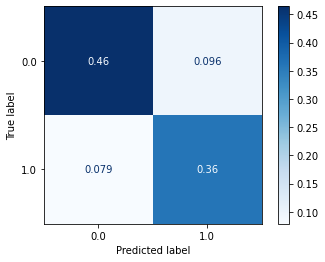

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

**Model 3: Random Forest**

Accuracy = 0.8911935313763403
ROC Area under Curve = 0.8908130428372483
Cohen's Kappa = 0.7797442831657269
Time taken = 12.54336404800415
              precision    recall  f1-score   support

         0.0    0.91011   0.89399   0.90197     66897
         1.0    0.86807   0.88764   0.87775     52572

    accuracy                        0.89119    119469
   macro avg    0.88909   0.89081   0.88986    119469
weighted avg    0.89161   0.89119   0.89131    119469



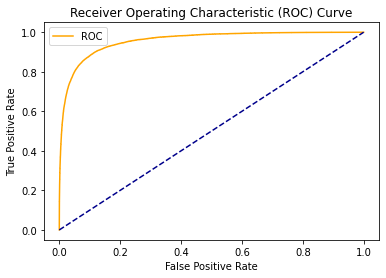

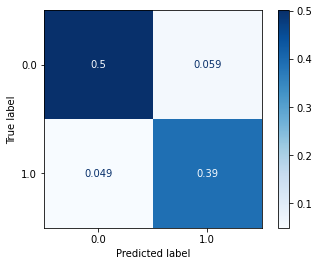

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

**Model 4: Neural Network (Multilayer Perceptron)**

Accuracy = 0.8842628631695252
ROC Area under Curve = 0.8831397507914652
Cohen's Kappa = 0.7654143482687883
Time taken = 132.94791769981384
              precision    recall  f1-score   support

         0.0    0.89997   0.89251   0.89622     66897
         1.0    0.86465   0.87377   0.86919     52572

    accuracy                        0.88426    119469
   macro avg    0.88231   0.88314   0.88270    119469
weighted avg    0.88443   0.88426   0.88433    119469



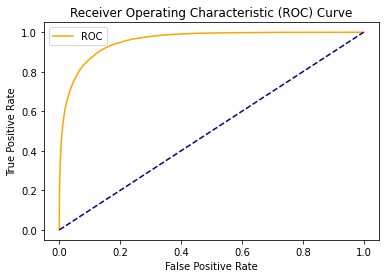

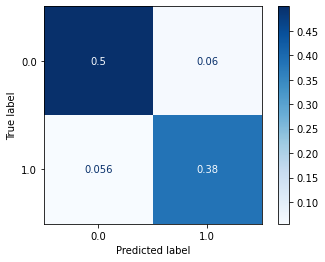

In [ ]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)